# Computer Lab 5: Modeling Non-Stationary Time Series Data

In [317]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns

from astsadata import *

In [318]:
def acf1(x, nlags=None, acf_type='correlation', pacf=False, ax=None, return_values=False, **kwargs):
    """
    Calculate and optionally plot the autocorrelation or partial autocorrelation function.

    Parameters:
    - x: Input time series.
    - nlags: Number of lags to compute.
    - acf_type: 'correlation' for autocorrelation, 'covariance' for autocovariance.
    - pacf: If True, computes partial autocorrelation instead of autocorrelation.
    - ax: Matplotlib axis to plot on. If None, a new axis is created.
    - return_values: If True, the function will return the ACF/PACF values and lags.
    - **kwargs: Additional keyword arguments for the plot.

    Returns:
    - If return_values is True, returns (lags, values).
    """
    lags = np.arange(1, nlags + 1)

    if pacf:
        if acf_type == 'correlation':
            values = sm.tsa.pacf(x, nlags=nlags)[1:]
            ylabel = 'PACF'
    else:
        if acf_type == 'correlation':
            values = sm.tsa.acf(x, nlags=nlags, fft=False)[1:]
            ylabel = 'ACF'
        elif acf_type == 'covariance':
            values = sm.tsa.acovf(x, nlag=nlags)[1:]
            ylabel = 'ACoV'

    if return_values:
        return lags, values

    if ax is None:
        ax = plt.gca()

    ax.bar(lags, values, **kwargs)
    ax.axhline(0, color='black', linewidth=1)
    if acf_type == 'correlation':
        conf_level = 1.96 / np.sqrt(x.shape[0])
        ax.axhline(conf_level, color='red', linestyle='--', linewidth=1)
        ax.axhline(-conf_level, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel('LAG')
    ax.set_ylabel(ylabel)

    return ax


## I. Integrated Autoregressive Moving Average (ARIMA) Models

### 1. Case Study: Quarterly U.S. GNP from 1947 to 2001

In [319]:
# Read the dataset
path = r'C:\zshahpouri\Forecasting_Predictive_Analytics\data\products_demand_data_series.csv'
df = pd.read_csv(path, index_col = 0, parse_dates = True)
start_date = "2019-07-08"
df.index = pd.date_range(start=start_date, periods=len(df), freq="D")

df.index = pd.to_datetime(df.index, format="%Y-%m-%d")  # Adjust format as needed
rename_dict = {
    "ProductP1": "p1",
    "ProductP2": "p2",
    "ProductP3": "p3",
    "ProductP4": "p4",
    "ProductP5": "p5",
    "temperature": "temp"
}

df.rename(columns=rename_dict, inplace=True)
df.drop(['price', 'p5'], axis=1, inplace=True)
df = df.astype(float)

C:\Users\zshah\AppData\Local\Temp\ipykernel_67464\2887809103.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col = 0, parse_dates = True)


In [320]:
df

,p1,p2,p3,p4,temp
2019-07-08,197.0,66.0,266.0,113.0,18.0
2019-07-09,153.0,44.0,264.0,74.0,21.0
2019-07-10,128.0,55.0,317.0,116.0,19.0
2019-07-11,133.0,57.0,390.0,70.0,17.0
2019-07-12,120.0,47.0,440.0,141.0,18.0
...,...,...,...,...,...
2019-10-11,174.0,226.0,975.0,94.0,2.0
2019-10-12,158.0,201.0,1141.0,91.0,3.0
2019-10-13,145.0,217.0,881.0,46.0,3.0
2019-10-14,161.0,249.0,741.0,70.0,7.0


## III. Hybrid SARIMA-Regression Models

In [321]:
log_data = np.log(df[:-14])

# Test set
log_test = np.log(df[-14:])

In [322]:
# Prepare exogenous variables
exog_train = log_data.loc[log_data.index, ['p2', 'temp']]
exog_test = log_test.loc[log_test.index, ['p2', 'temp']]

# Verify the shapes
print(f"Exogenous Train Shape: {exog_train.shape}")
print(f"Exogenous Test Shape: {exog_test.shape}")

Exogenous Train Shape: (86, 2)
Exogenous Test Shape: (14, 2)


In [323]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Fit the SARIMAX model with exogenous variables
model_exog = SARIMAX(log_data['p3'], order=(0, 1, 1), seasonal_order=(0, 1, 1, 7), exog=exog_train['temp'])
results_exog = model_exog.fit()

# Display model summary
print(results_exog.summary())


                                     SARIMAX Results                                     
Dep. Variable:                                p3   No. Observations:                   86
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood                  56.430
Date:                           Sat, 08 Feb 2025   AIC                           -104.859
Time:                                   12:17:51   BIC                            -95.432
Sample:                               07-08-2019   HQIC                          -101.085
                                    - 10-01-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp          -0.0537      0.031     -1.735      0.083      -0.114       0.007
ma.L1         -0.8843      0.075    -11.858

---------------

-------------

--------------

In [ ]:
# ---------- Set Random Seed for Reproducibility ----------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [324]:
data = df['p3']

k = 14
train_data = data[:-2*k]
test_data = data[-2*k:]

In [325]:
dataset_train = train_data.values
dataset_train = np.reshape(dataset_train, (-1,1)) 
dataset_test = test_data.values 
dataset_test = np.reshape(dataset_test, (-1,1))  

In [326]:
# Normalize the dataset from 0 to 1
# Normalization a crucial data preprocessing step to improve machine learning model effectiveness

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test)  

In [327]:
# Divide the time series data into X_train and y_train for training set, and X_test and y_test for test set, 
# to frame it as a supervised learning problem for model training

# Training set
X_train = []
y_train = []
for i in range(k, len(scaled_train)):
    X_train.append(scaled_train[i-k:i, 0])
    y_train.append(scaled_train[i, 0])

# Test set
X_test = []
y_test = []
for i in range(k, len(scaled_test)):
    X_test.append(scaled_test[i-k:i, 0])
    y_test.append(scaled_test[i, 0])

In [328]:
# Convert the data into a format suitable for input to an RNN
# Transform the X-array into a 3-dimensional array with the shape (samples, time steps, features)
# Transform the y-array into a 2-dimensional array with the shape (samples, features)

# Training set
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

# Test set
X_test, y_test = np.array(X_test), np.array(y_test)
 
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))


In [329]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error

# SimpleRNN model

# Initialize the RNN
regressor = Sequential()

# Add RNN layers and dropout regularization
regressor.add(SimpleRNN(units = k, 
                        activation = "tanh",
                        return_sequences = True,
                        input_shape = (X_train.shape[1],1)))

regressor.add(Dropout(0.2))
 
regressor.add(SimpleRNN(units = k, 
                        activation = "tanh",
                        return_sequences = True))
 
regressor.add(SimpleRNN(units = k,
                        activation = "tanh",
                        return_sequences = True))
 
regressor.add(SimpleRNN(units = k))
 
# Add the output layer
regressor.add(Dense(units = 1,activation='sigmoid'))
 
# Compile RNN
regressor.compile(optimizer = SGD(learning_rate=0.01,
                                  momentum=0.9, 
                                  nesterov=True), 
                  loss = "mean_squared_error")
 
# Fit the model
regressor.fit(X_train, y_train, epochs = 20, batch_size = 2)
regressor.summary()


Epoch 1/20


c:\Users\zshah\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0581
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0321
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0170
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068    
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0095
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086
Epoch 16/20
29/29 ━━━━━━━━

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_32 (SimpleRNN)       │ (None, 14, 14)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 14, 14)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_33 (SimpleRNN)       │ (None, 14, 14)         │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_34 (SimpleRNN)       │ (None, 14, 14)         │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_35 (SimpleRNN)       │ (None, 14)             │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,916 (11.39 KB)

 Trainable params: 1,457 (5.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,459 (5.70 KB)

In [330]:
# Forecast using X_test data

y_RNN = regressor.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


In [331]:
# Scale back from 0-1 to original

y_RNN_O = scaler.inverse_transform(y_RNN) 

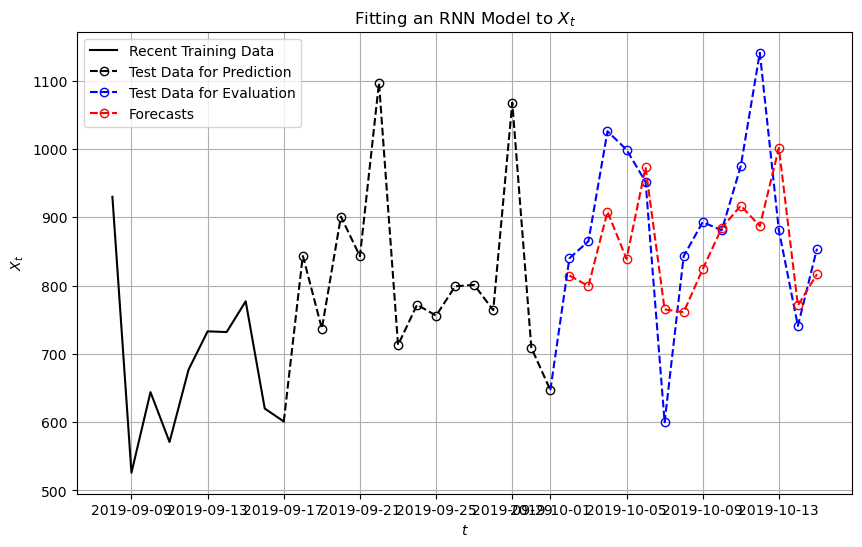

In [332]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Define how much past training data to keep for context
train_keep = 10   # Adjust this if needed

# Training data plot (only keeping the last `train_keep` points)
plt.plot(train_data.index[-train_keep:], train_data[-train_keep:], color='black', linestyle='-')

# Test data plots
plt.plot(test_data.index[:k], test_data[:k], color='black', linestyle='--', marker='o', markerfacecolor='none')  # Prediction period
plt.plot(test_data.index[k:], test_data[k:], color='blue', linestyle='--', marker='o', markerfacecolor='none')  # Evaluation period

# Forecasts plot (adjusted to be one-step ahead)
plt.plot(test_data.index[k:], y_RNN_O, color='red', linestyle='--', marker='o', markerfacecolor='none')

# Connecting last training point to first test point
plt.plot([train_data.index[-1], test_data.index[0]], [train_data.iloc[-1], test_data.iloc[0]], 'k--')

# Connecting last predicted test point to first evaluation test point
plt.plot([test_data.index[k-1], test_data.index[k]], [test_data.iloc[k-1], test_data.iloc[k]], 'b--')

# Custom legend elements
legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', markeredgecolor='black', label='Recent Training Data'),
    Line2D([0], [0], color='black', linestyle='--', marker='o', markerfacecolor='none', markeredgecolor='black', label='Test Data for Prediction'),
    Line2D([0], [0], color='blue', linestyle='--', marker='o', markerfacecolor='none', markeredgecolor='blue', label='Test Data for Evaluation'),
    Line2D([0], [0], color='red', linestyle='--', marker='o', markerfacecolor='none', markeredgecolor='red', label='Forecasts'),
]

plt.title('Fitting an RNN Model to $X_t$')
plt.xlabel('$t$')
plt.ylabel('$X_t$')
plt.legend(handles=legend_elements, loc='upper left')
plt.grid(True)
plt.show()


In [333]:
# Calculate the Mean Absolute Percentage Error (MAPE)

errors = np.abs((test_data.values[-k:] - y_RNN_O) / test_data.values[-k:])
mape_rnn = np.mean(errors) * 100

print(f'The Mean Absolute Percentage Error (MAPE) is: {mape_rnn:.2f}%')


The Mean Absolute Percentage Error (MAPE) is: 13.64%


---------------

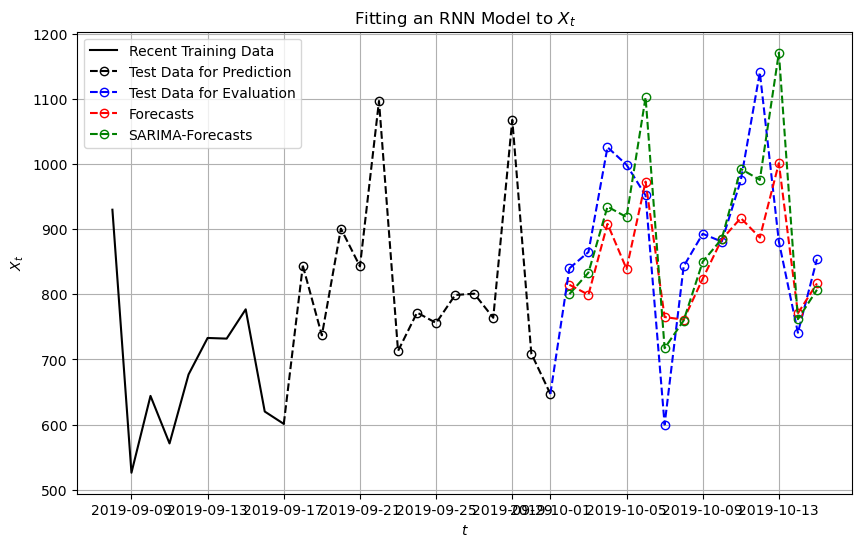

In [334]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))


# Training data plot (only keeping the last `train_keep` points)
plt.plot(train_data.index[-10:], train_data[-10:], color='black', linestyle='-')

# Test data plots
plt.plot(test_data.index[:k], test_data[:k], color='black', linestyle='--', marker='o', markerfacecolor='none')  # Prediction period
plt.plot(test_data.index[k:], test_data[k:], color='blue', linestyle='--', marker='o', markerfacecolor='none')  # Evaluation period

# Forecasts plot
plt.plot(test_data.index[k:], y_RNN_O, color='red', linestyle='--', marker='o', markerfacecolor='none')

# SARIMA-Forecasts plot
plt.plot(forecast_df.index, forecast_df['predicted_mean'], color='green', linestyle='--', marker='o', markerfacecolor='none')

# Connecting last training point to first test point
plt.plot([train_data.index[-1], test_data.index[0]], [train_data.iloc[-1], test_data.iloc[0]], 'k--')

# Connecting last predicted test point to first evaluation test point
plt.plot([test_data.index[k-1], test_data.index[k]], [test_data.iloc[k-1], test_data.iloc[k]], 'b--')

# Custom legend elements
legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', markeredgecolor='black', label='Recent Training Data'),
    Line2D([0], [0], color='black', linestyle='--', marker='o', markerfacecolor='none', markeredgecolor='black', label='Test Data for Prediction'),
    Line2D([0], [0], color='blue', linestyle='--', marker='o', markerfacecolor='none', markeredgecolor='blue', label='Test Data for Evaluation'),
    Line2D([0], [0], color='red', linestyle='--', marker='o', markerfacecolor='none', markeredgecolor='red', label='Forecasts'),
    Line2D([0], [0], color='green', linestyle='--', marker='o', markerfacecolor='none', markeredgecolor='green', label='SARIMA-Forecasts'),

]

plt.title('Fitting an RNN Model to $X_t$')
plt.xlabel('$t$')
plt.ylabel('$X_t$')
plt.legend(handles=legend_elements, loc='upper left')
plt.grid(True)
plt.show()


----

In [335]:
forecast_df = pd.read_csv("forecast_df.csv", index_col=0, parse_dates=True)
sarima_pred = forecast_df['predicted_mean']
sarima_pred

2019-10-02     800.366841
2019-10-03     833.386572
2019-10-04     934.726947
2019-10-05     918.700097
2019-10-06    1102.629871
2019-10-07     717.249414
2019-10-08     759.803123
2019-10-09     850.100999
2019-10-10     885.172550
2019-10-11     992.810135
2019-10-12     975.787389
2019-10-13    1171.146412
2019-10-14     761.818721
2019-10-15     807.016684
Name: predicted_mean, dtype: float64

In [336]:
# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(32, activation='tanh'))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# LSTM Predictions on training data
lstm_predictions = lstm_model.predict(X_train)
lstm_predictions = lstm_predictions.flatten()[:len(y_train)]

# Forecast with SARIMA using the pre-calculated SARIMA predictions (no recalculation needed)
sarima_model = SARIMAX(y_train, order=(0, 1, 1), seasonal_order=(0, 1, 1, 7), exog=lstm_predictions.reshape(-1, 1))
sarima_results = sarima_model.fit(disp=False)

# Forecast using SARIMA + LSTM
forecast_period = len(y_test)
sarima_forecast = sarima_results.predict(start=len(y_train), end=len(y_train) + forecast_period - 1, exog=lstm_model.predict(X_test))

# Inverse scaling
sarima_forecast_inverse = scaler.inverse_transform(sarima_forecast.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/50


c:\Users\zshah\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.2831 - val_loss: 0.0405
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0376 - val_loss: 0.0495
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0344 - val_loss: 0.0136
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0300 - val_loss: 0.0187
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0301 - val_loss: 0.0079
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0221 - val_loss: 0.0099
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0232 - val_loss: 0.0080
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0230 - val_loss: 0.0082
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0225 - val_loss: 0.0081
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0232 - val_loss: 0.0082
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0227 - val_loss: 0.0079
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0224 - val_loss: 0.0085
Epoch 13/50


Epoch 1/50


c:\Users\zshah\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0961 - val_loss: 0.0288
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0188 - val_loss: 0.0196
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0196 - val_loss: 0.0440
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0148 - val_loss: 0.0245
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0147 - val_loss: 0.0214
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0159 - val_loss: 0.0289
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0141 - val_loss: 0.0236
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0132 - val_loss: 0.0237
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0136 - val_loss: 0.0228
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0150 - val_loss: 0.0227
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0140 - val_loss: 0.0223
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0145 - val_loss: 0.0231
3/3 ━━━━━━━━

c:\Users\zshah\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
The Hybrid Model MAPE is: 7.73%


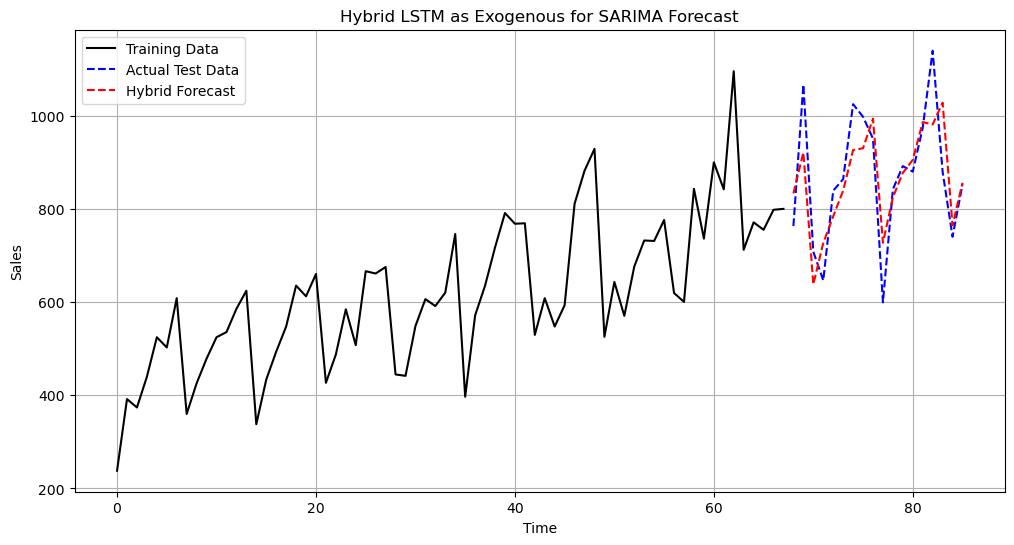

In [347]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import random
import os
from matplotlib.lines import Line2D

# ---------- Set Random Seed for Reproducibility ----------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Selecting ProductP3 as the target variable
target = df['p3'].values

# Scaling the dataset
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(target.reshape(-1, 1))

# LSTM Model for entire dataset
k = 14  # Lag
X, y = [], []
for i in range(k, len(scaled_data)):
    X.append(scaled_data[i-k:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Splitting into training and testing data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(32, activation='tanh'))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train LSTM model
lstm_model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# LSTM Predictions (aligned with training data length)
lstm_predictions = lstm_model.predict(X_train)

# Ensure the lengths match
lstm_predictions = lstm_predictions.flatten()[:len(y_train)]

# SARIMA with exogenous variable (LSTM predictions)
sarima_model = SARIMAX(y_train, order=(0, 1, 1), seasonal_order=(0, 1, 1, 7), exog=lstm_predictions.reshape(-1, 1))
sarima_results = sarima_model.fit(disp=False)

# Forecast using SARIMA + LSTM
forecast_period = len(y_test)
sarima_forecast = sarima_results.predict(start=len(y_train), end=len(y_train) + forecast_period - 1, exog=lstm_model.predict(X_test))

# Inverse scaling
sarima_forecast_inverse = scaler.inverse_transform(sarima_forecast.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# MAPE Calculation
mape = np.mean(np.abs((y_test_inverse - sarima_forecast_inverse) / y_test_inverse)) * 100
print(f"The Hybrid Model MAPE is: {mape:.2f}%")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train)), scaler.inverse_transform(y_train.reshape(-1, 1)), color='black', label='Training Data')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test_inverse, color='blue', linestyle='--', label='Actual Test Data')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), sarima_forecast_inverse, color='red', linestyle='--', label='Hybrid Forecast')

plt.title('Hybrid LSTM as Exogenous for SARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()